## SMIB

Synchronous Machine Infinite Bus (SMIB) system


### System analysis and simulation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pydae.grid_tools as gt
import pydae.ssa as ssa
from IPython.core.display import HTML,SVG
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

#### Initialization

In [9]:
import smib

In [10]:
model = smib.model()
model.ini({'p_c_1':1.0,'T_b_1':1.0,'b_1_2':-5,'P_1':50.0e6},'xy_0.json')

True

#### Small signal analysis

In [11]:
ssa.A_eval(model)
damp = ssa.damp_report(model)
damp.sort_values('Damp').round(2)

,Real,Imag,Freq.,Damp
Mode 6,-2.73,11.84,1.88,0.22
Mode 7,-2.73,-11.84,1.88,0.22
Mode 1,-1.00,0.00,0.00,1.00
Mode 2,-1.00,0.00,0.00,1.00
Mode 3,-0.01,0.00,0.00,1.00
Mode 4,-96.40,0.00,0.00,1.00
Mode 5,-47.39,0.00,0.00,1.00
Mode 8,-5.90,0.00,0.00,1.00
Mode 9,-2.17,0.00,0.00,1.00
Mode 10,-0.94,0.00,0.00,1.00


#### Time domain simulation

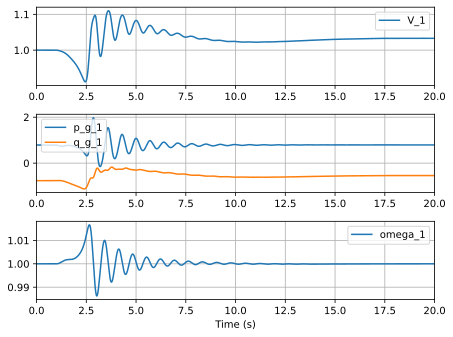

In [12]:
model = smib.model()
model.Dt = 0.01
model.decimation = 1
model.ini({'v_ref_1':1.0, 'K_a_1':200.0,'b_1_2':-5,'P_1':50.0e6},'xy_0.json')
model.run( 1.0,{})
model.run(30.0,{'v_ref_1':1.05})
model.post();

fig,axes = plt.subplots(nrows=3)

axes[0].plot(model.Time,  model.get_values('V_1'),label='V_1')

axes[1].plot(model.Time,  model.get_values('p_g_1'),label='p_g_1')
axes[1].plot(model.Time,  model.get_values('q_g_1'),label='q_g_1')

axes[2].plot(model.Time,  model.get_values('omega_1'),label='omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,20])
ax.set_xlabel('Time (s)')
fig.tight_layout()


In [13]:
ssa.ss_eval(model)

<16x16 sparse matrix of type '<class 'numpy.float64'>'
	with 65 stored elements in Compressed Sparse Row format>

In [14]:
model.B

<16x12 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [15]:
import modred as mr

A = model.A.toarray()
B = model.B.toarray()
C = model.C.toarray()

N_x = A.shape[0]
N_r = 6
# Create random modes
basis_vecs = np.random.random((N_x, N_r))

# Perform Galerkin projection and save data
LTI_proj = mr.LTIGalerkinProjectionArrays(basis_vecs)
A_reduced, B_reduced, C_reduced = LTI_proj.compute_model(
    A.dot(basis_vecs), B, C.dot(basis_vecs))

In [16]:
w_red,v = np.linalg.eig(A_reduced)

In [17]:
import control

In [18]:
sys = control.ss(model.A.toarray(),model.B.toarray(),model.C.toarray(),model.D.toarray())

In [19]:
rsys = control.modred(sys, [0], method='truncate')

In [20]:
rsys = control.balred(sys, 6, method='truncate')

In [21]:
w_red,v_red = np.linalg.eig(rsys.A) 
w,v = np.linalg.eig(model.A.toarray()) 

In [22]:
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle

def plot_eig(eigenvalues, x_min='',x_max='',y_min='',y_max='', fig=''):
    ''''
    Creates a matplotlib figure from a numapy array of eigenvalues.


    
    '''
    pi2 = 2*np.pi
    
    if fig == '':
        fig,axes = plt.subplots()
    
    
        #damping zones
        ## damping zone > 10%
        e_real = -10000.0
        damp = 0.1
        e_imag = np.sqrt((e_real/damp)**2-e_real**2)/pi2
        poly = Polygon([(0,0),(e_real,0),(e_real,e_imag)], facecolor='#e1f2e1',zorder=0)
        axes.add_patch(poly)
        #axes.text(-0.85, 0.5, '$\zeta>10\%$', fontsize=12)
    
        ## damping zone from  5% to 10%
        axes.plot([0,e_real],[0, e_imag],'--', color='k',zorder=0)
        axes.plot([0,e_real],[0,-e_imag],'--', color='k',zorder=0)
        poly = Polygon([(0,0),(e_real,e_imag),(0,e_imag)], facecolor='#fae8ce',zorder=0)
        axes.add_patch(poly)
        #axes.text(-0.87, 9.0/pi2, '$10\% <\zeta<5\%$', fontsize=12)
    
        ## damping zone <5%
        e_real = -100000.0
        damp = 0.05
        e_imag = np.sqrt((e_real/damp)**2-e_real**2)/pi2
        axes.plot([0,e_real],[0, e_imag],'--', color='k',zorder=0)
        axes.plot([0,e_real],[0,-e_imag],'--', color='k',zorder=0)
        poly = Polygon([(0,0),(e_real,e_imag),(0,e_imag)], facecolor='#f7dcda',zorder=0)
        axes.add_patch(poly)
        #axes.text(-0.37, 9.0/pi2, '$\zeta<$5 %', fontsize=12)
    
        axes.plot([0,0],[-20,20],'-', color='k', lw=4)

        if x_min == '': x_min = np.min(eigenvalues.real)*1.1
        if x_max == '': x_max = np.max(eigenvalues.real)
        if y_min == '': y_min = np.min(eigenvalues.imag)/(2*np.pi)*1.1
        if y_max == '': y_max = np.max(eigenvalues.imag)/(2*np.pi)*1.1
            
        axes.set_xlim((x_min,x_max))
        axes.set_ylim((y_min,y_max))
        axes.grid(True)
        axes.set_xlabel('Real')
        axes.set_ylabel('Imag$/2\pi$ (Hz)')
    
    axes = fig.axes[0]
    axes.plot(eigenvalues.real,eigenvalues.imag/(2*np.pi),'o')
    fig.tight_layout()
    
    return fig

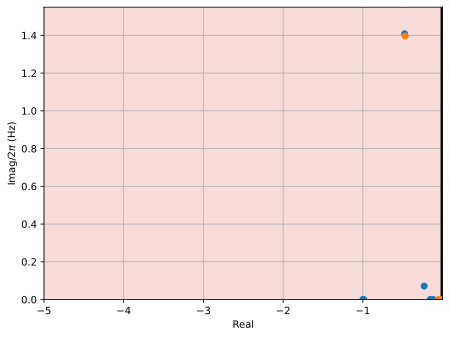

In [23]:
fig = plot_eig(w, x_min=-5,x_max='',y_min=0,y_max='', fig='');
fig = plot_eig(w_red, x_min=-5,x_max='',y_min=0,y_max='', fig=fig);

[<AxesSubplot:xlabel='Real', ylabel='Imag$/2\\pi$ (Hz)'>]

In [35]:
model.report_u()

P_1   = 0.00
Q_1   = 0.00
P_2   = 0.00
Q_2   = 0.00
v_ref_1 = 1.05
p_c_1 = 0.80
alpha_2 = 0.00
v_ref_2 = 1.00
omega_ref_2 = 1.00
phi_2 = 0.00


In [36]:
u_idxs = [0,1]
B_c = B[:,u_idxs]*1e9

In [37]:
Q = np.eye(N_x)
Q[0,0] = 1
Q[1,1] = 1

R = 1.0*np.eye(2)

K_lqr, S, E = control.lqr(A,B_c,Q,R)
w_lqr,v_lqr = np.linalg.eig(A - B_c@K_lqr) 

In [46]:
K_place = control.place(A,B_c,w-0.1)
w_place,v_place = np.linalg.eig(A - B_c@K_place) 

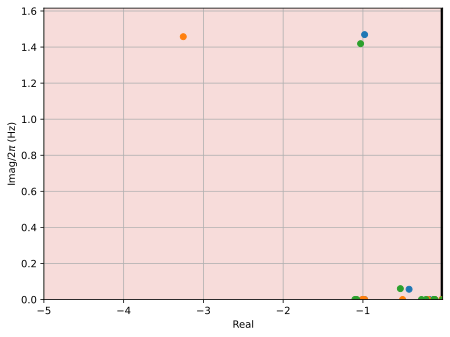

In [47]:
fig = plot_eig(w, x_min=-5,x_max='',y_min=0,y_max='', fig='');
fig = plot_eig(w_lqr, x_min=-5,x_max='',y_min=0,y_max='', fig=fig);
fig = plot_eig(w_place, x_min=-5,x_max='',y_min=0,y_max='', fig=fig);

In [162]:
K

array([[ 1.74353976e+00,  1.07313071e+02, -4.75127268e-01,
         3.93738482e-01,  2.24572913e-01,  1.64836177e-01,
         1.75209507e-01,  2.93036947e-01, -3.77347518e-02,
         5.09732123e-01,  1.50683156e-01, -2.49151101e-01,
         9.06145535e-01, -1.19766020e+02, -2.10228449e-09],
       [ 5.47912811e-01, -3.65870560e+01, -9.64547585e-02,
         1.52898182e-01,  1.92104697e+00, -2.93053386e+00,
        -3.15741990e+00, -5.41433694e-02, -3.15712765e-03,
         3.23693175e+00,  8.27686808e-01, -1.89873446e+00,
        -3.68673692e-01, -2.05895913e+01, -2.14753736e-10]])

In [116]:
control.place?

In [147]:
B_c

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.32965797e-10, -2.58493853e-11],
       [ 1.61433938e-10,  2.05795507e-10],
       [-1.87673398e-09,  1.40148929e-09],
       [ 6.37593658e-09,  4.18619586e-08],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

In [5]:
np.sqrt(3)/2

0.8660254037844386